# VLSI - SAT Part
Di Tuccio Gianluca, Orsini Lorenzo<br>
In this notebook we've performed two types of encoding: 3D and 2D, as proposed by Takehide Soh et al.

In [1]:
from tqdm import tqdm
from z3 import *
from numpy import random
import os
import pandas as pd



'''
SET HERE THE PATH OF THE MAIN FOLDER (i.e VLSI folder)
            |
            |
            V
'''
os.chdir('/Users/gianlucadituccio/Documents/VLSI')
from utils.utils import *

## SAT 3D
The first encoding we evaluate was the 3D SAT, as proposed in the tutorials of the course.<br>
The 3D matrix is called plate where the width and height correspon to all the coordinates of the plate (i.e. w x h), while the third dimension represents the rectangles. We've simply found any possible position in the plate for any rectangle (using sliding window), we've assigned the higher rectangle in (0,0) coordinate and we've implied that there must be exactly one possible position for each rectangle and there must be at most one rectangle for each coordinate. As you can see, this encoding is very slow and requires an high computational cost (O: n*w*h), so we've tried with a different encoding (i.e. 2D SAT).

In [ ]:
# functions used for extracting the left-bottom coordinate of each rectangle
def FindCoordinates(solution, plate, rectangle):
    w,h,z = plate.shape
    for j in range(h):
        for i in range(w):
            if solution.evaluate(plate[i][j][rectangle]):
                return i,j

def BuildCoordinates(solution, plate, rectangles):
    x_positions = []
    y_positions = []
    for i in range(rectangles):
        x, y = FindCoordinates(solution=solution, plate=plate, rectangle=i)
        x_positions.append(x)
        y_positions.append(y)
    return x_positions, y_positions

In [ ]:
def SAT3D(parameters, height, timeout=300):
    try:
        n = parameters['n_rectangles']
        
        w = parameters['w']
        
        # start the timer of the execution
        # the time for constraints is inglobed inside the timeout
        t_constraint = time.process_time()
        if t_constraint>timeout*1000: return {}
        
        rectangles = [(x, y, i) for i, (x, y) in enumerate(zip(parameters['x_components'], parameters['y_components']))]
        sorted_rectangles = sorted(rectangles, key=lambda x: (x[1],x[0]), reverse=True)
        x_components = [k[0] for k in sorted_rectangles]
        y_components = [k[1] for k in sorted_rectangles]
        original_indices = [k[2] for k in sorted_rectangles]
        
        plates = [[[Bool(f"square_{i}_{j}_{k}") for k in range(1,n+1)] for j in range(height)] for i in range(w)]
        plates = np.asarray(plates, dtype=BoolRef)
        solver = Solver()
       
        # the highest block is set in zero
        solver.add(plates[0,0,0])

        # in each coordinates there must be at most one rectangle
        for i in range(w):
            for j in range(height):
                solver.add(at_most_one([plates[i,j,k] for k in range(n)]))
            if t_constraint>timeout*1000: return {}
                
        
        # create all the possibilities, i.e. all the coordinates position for each rectangle
        # using numpy sliding window
        all_poss = []
        for rectangle in range(n):
            possibilities = []
            tmp = np.lib.stride_tricks.sliding_window_view(plates, window_shape=(x_components[rectangle],y_components[rectangle],1))
            tmp = tmp.reshape((tmp.shape[0]*tmp.shape[1], n, x_components[rectangle], y_components[rectangle]))    
            r = range(0,tmp.shape[0])
            for possibility in r:
                tmp2 = list(tmp[possibility,rectangle,:,:].flatten())
                possibilities.append(And(tmp2))
            solver.add(exactly_one(possibilities))
            if t_constraint>timeout*1000: return {}
        
        solver.set('timeout', timeout*1000-int(t_constraint))
        t_check = time.process_time()
        if solver.check() == sat:
            solution = solver.model()
            
            # build the left-bottom coordinates for each rectangle
            x_pos, y_pos = BuildCoordinates(solution, plates, n)
            
            # re-take the original order of the rectangles
            positions = [(x, y, i, z, k) for x, y, i, z, k in zip(x_pos, y_pos, x_components, y_components, original_indices)]
            x_pos, y_pos, x_comp, y_comp, _ = zip(*sorted(positions, key=lambda x: x[4]))
            return {'h':height, 
                    'W':w,
                    'x_positions':x_pos, 
                    'y_positions':y_pos, 
                    'x_components':x_comp,
                    'y_components':y_comp}
        else: 
            # if the model is UNSAT, try to increase the height (ricorsive)
            # the new timeout is computed as initial timeout minus the time for constraints and solver.check
            return SAT3D(parameters, height=height+1, timeout=timeout-int(t_check/1000)-int(t_constraint/1000))
    except Exception as ex: print(ex)

## 2D SAT
The other approach was the one proposed in the paper 'A SAT-based Method for Solving the
Two-dimensional Strip Packing Problem'.

In [ ]:
# functions used for extracting the left-bottom coordinate of each rectangle
def FindCoordinates2D(solution, plate, rectangle):
    for i in range(len(plate[0])):
        if solution.evaluate(plate[rectangle][i]):
            return i

def BuildCoordinates2D(solution, plate, rectangles):
    positions = []
    for i in range(rectangles):
        pos = FindCoordinates2D(solution=solution, plate=plate, rectangle=i)
        positions.append(pos)
    return positions

def BuildRotationClause(clause):
    global rot, rotation
    return Or(And(Not(rot[i]),clause),And(rot[i],Not(clause))) if rotation else clause

In [ ]:
def SAT2D(parameters, height, timeout=300):
    try:
        # declaration the variables for the current instance
        w = parameters['w']
        n = parameters['n_rectangles']
        solver = Solver()
        
        # start the timer of the execution
        # the time for constraints is inglobed inside the timeout
        t_constraint = time.process_time()
        if t_constraint>timeout*1000: return {}
        
        # declaration of the plate (i.e. all possible coordinates)
        # first index --> rectangle; second index --> coordinates from 0 to w
        px = [[Bool(f"px_{i+1}_{e}") for e in range(w)] for i in range(n)]
        
        # first index --> rectangle; second index --> coordinates from 0 to height
        py = [[Bool(f"py_{i+1}_{f}") for f in range(height)] for i in range(n)]
        
        # declaration of the left-right rectangles positions
        lr = [[Bool(f"lr_{i+1}_{j+1}") for j in range(n)] for i in range(n)]
        ud = [[Bool(f"ud_{i+1}_{j+1}") for j in range(n)] for i in range(n)]
        
        # sort rectangles by y component
        rectangles = [(x, y, i) for i, (x, y) in enumerate(zip(parameters['x_components'], parameters['y_components']))]
        sorted_rectangles = sorted(rectangles, key=lambda x: (x[1],x[0]), reverse=True)
        x_components = [k[0] for k in sorted_rectangles]
        y_components = [k[1] for k in sorted_rectangles]
        original_indices = [k[2] for k in sorted_rectangles]
        
        # create a list of tuples (i.e. each tuple has the x and y component of each rectangle)
        rectangles = []
        for i in range(n):
            rectangles.append((x_components[i],y_components[i]))
        
        # the higher block must be positioned in 0 (note: all the block have been already sorted)
        # so, we the first rectangle must be in (0,0) coordinate  
        solver.add(px[0][0])
        solver.add(py[0][0])
        
        
        for i in range(n):
            
            # rectangle must be placed
            for e in range(w-rectangles[i][0],w):
                solver.add(px[i][e])
            for f in range(height-rectangles[i][1],height):
                solver.add(py[i][f])
            
            # order encoding (PAPER)
            for e in range(w-rectangles[i][0]):
                solver.add(Or(Not(px[i][e]), px[i][e+1]))
            for f in range(height-rectangles[i][1]):
                solver.add(Or(Not(py[i][f]), py[i][f+1])) 
        if t_constraint>timeout*1000: return {}
        
        # some reduction (PAPER)
        for i in range(n):
            for j in range(n):
                if i!=j:
                
                    # large rectangle (PAPER)
                    if rectangles[i][0] + rectangles[j][0] > w:
                        solver.add(And(Not(lr[i][j]), Not(lr[j][i])))
                    if rectangles[i][1] + rectangles[j][1] > height:
                        solver.add(And(Not(ud[i][j]), Not(ud[j][i])))
        
        if t_constraint>timeout*1000: return {}
                
        # non overlapping (PAPER)
        for i in range(n):
            for j in range(i+1,n):
                
                # non overlpapping (PAPER) --> constraint 5
                solver.add(Or(Not(lr[i][j]), Not(px[j][rectangles[i][0]-1])))
                for e in range(0, w-rectangles[i][0]-1):
                    solver.add(Or(Not(lr[i][j]), px[i][e], Not(px[j][e+rectangles[i][0]])))
                solver.add(Or(Not(lr[i][j]),px[i][w - rectangles[i][0]-1]))

                solver.add(Or(Not(lr[j][i]), Not(px[i][rectangles[j][0]-1])))
                for e in range(0, w-rectangles[j][0]-1):
                    solver.add(Or(Not(lr[j][i]), px[j][e], Not(px[i][e+rectangles[j][0]])))
                solver.add(Or(Not(lr[j][i]),px[j][w - rectangles[j][0]-1]))

                solver.add(Or(Not(ud[i][j]), Not(py[j][rectangles[i][1]-1])))
                for f in range(0, height-rectangles[i][1]-1):
                    solver.add(Or(Not(ud[i][j]), py[i][f], Not(py[j][f+rectangles[i][1]])))
                solver.add(Or(Not(ud[i][j]),py[i][height - rectangles[i][1]-1]))

                solver.add(Or(Not(ud[j][i]), Not(py[i][rectangles[j][1]-1])))
                for f in range(0, height-rectangles[j][1]-1):
                    solver.add(Or(Not(ud[j][i]), py[j][f], Not(py[i][f+rectangles[j][1]])))
                solver.add(Or(Not(ud[j][i]),py[j][height - rectangles[j][1]-1]))
                
                # non overlapping (PAPER) --> constraint 4
                solver.add(Or(lr[i][j], lr[j][i], ud[i][j], ud[j][i]))
        
        if t_constraint>timeout*1000: return {}
                
        solver.set('timeout', timeout*1000-int(t_constraint))
        t_check = time.process_time()
        if solver.check() == sat:
            solution = solver.model()
            
            # build the left-bottom coordinates for each rectangle
            x_pos = BuildCoordinates2D(solution, px, n)
            y_pos = BuildCoordinates2D(solution, py, n)             
            
            # re-take the original order of the rectangles
            positions = [(x, y, i, z, k) for x, y, i, z, k in zip(x_pos, y_pos, x_components, y_components, original_indices)]
            x_pos, y_pos, x_comp, y_comp, _ = zip(*sorted(positions, key=lambda x: x[4]))

            return {'h':height, 
                    'W':w,
                    'x_positions':x_pos, 
                    'y_positions':y_pos, 
                    'x_components':x_comp,
                    'y_components':y_comp}
        else: 
            return SAT2D(parameters, height=height+1, timeout=timeout-int(t_check/1000)-int(t_constraint/1000))
    
    except Exception as ex: print(ex)

In [ ]:
for i in tqdm(range(1,41)):
    file = LoadInstance('utils/instances/',f'ins-{i}.txt')
    t0 = time.time()
    
    # if you want to use SAT3D, use SAT3D instead of SAT2D function, with the same parameters
    result = SAT2D(parameters=file, height=file['min_h'], timeout=300)
    t1 = time.time()
    time_computation = t1-t0
    if result:
        # if you want plot the results without saving them, use: PlotInstance(result)
        PlotInstance(result, 
                     path='SAT/images', 
                     name='fig-'+str(i))
        WriteInstance(result,
                     path='SAT/out',
                     name='out-'+str(i))
    else:
        print('Instance', i, 'TIMEOUT')

## SAT 2D VS SAT 3D

In [2]:
encodings = pd.read_csv('utils/datasets/SAT2D_SAT3D.csv')
Statistics({'SAT 3D':encodings['time_SAT3D'], 
            'SAT 2D':encodings['time']}, 
           {'h_min':encodings['h_min'], 
            'SAT 3D':encodings['h_SAT3D'], 
            'SAT 2D':encodings['h']},
            timeout=300)

TIMEOUT is seen as 300s.

+------------------+----------+----------+
|                  |   SAT 3D |   SAT 2D |
+------------------+----------+----------+
|  Total Time [s]  | 8783.336 | 1684.761 |
|     Max [s]      |    300.0 |    300.0 |
|     Min [s]      |    0.329 |    0.061 |
|     Mean [s]     |  219.583 |   42.119 |
|     Std [s]      |  127.244 |   93.701 |
| Instances Solved |    13/40 |    36/40 |
|    Optimal H     |    13/40 |    36/40 |
+------------------+----------+----------+


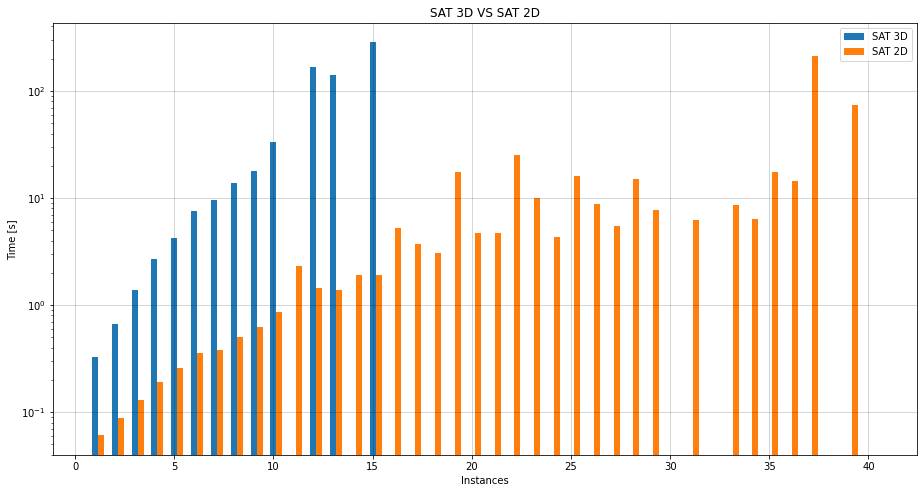

In [3]:
PlotStats({'SAT 3D':encodings['time_SAT3D'], 
            'SAT 2D':encodings['time']},
            x_axis=list(encodings['Instance']))

## SAT with/out Rotation

In [ ]:
def BuildRotationClause(left_clause, right_clause, rotation):
    left = left_clause.copy()
    right = right_clause.copy()
    left.append(Not(rotation))
    right.append(rotation)
    return Or(And(left),And(right))

In [ ]:
def SAT2DRotation(parameters, height, timeout=300):
    try:
        if height>=parameters['min_h']+4: return {} # after 4 iterations, return an empty result
        
        # declaration the variables for the current instance
        w = parameters['w']
        n = parameters['n_rectangles']
        solver = Solver()
        
        # start the timer of the execution
        # the time for constraints is inglobed inside the timeout
        t_constraint = time.process_time()
        if t_constraint>timeout*1000: return {}
        
        # declaration of the plate (i.e. all possible coordinates)
        # first index --> rectangle; second index --> coordinates from 0 to w
        px = [[Bool(f"px_{i+1}_{e}") for e in range(w)] for i in range(n)]
        
        # first index --> rectangle; second index --> coordinates from 0 to height
        py = [[Bool(f"py_{i+1}_{f}") for f in range(height)] for i in range(n)]
        
        # declaration of the left-right rectangles positions
        lr = [[Bool(f"lr_{i+1}_{j+1}") for j in range(n)] for i in range(n)]
        ud = [[Bool(f"ud_{i+1}_{j+1}") for j in range(n)] for i in range(n)]
        
        # rotation array of Bools
        rot = [Bool(f"r_{i+1}") for i in range(n)]
        
        # sort rectangles by y component
        rectangles = [(x, y, i) for i, (x, y) in enumerate(zip(parameters['x_components'], parameters['y_components']))]
        
        # sort rectangles by y component
        rectangles = [(x, y, i) for i, (x, y) in enumerate(zip(parameters['x_components'], parameters['y_components']))]
        sorted_rectangles = sorted(rectangles, key=lambda x: (x[1],x[0]), reverse=True)
        x_components = [k[0] for k in sorted_rectangles]
        y_components = [k[1] for k in sorted_rectangles]
        original_indices = [k[2] for k in sorted_rectangles] 
        
        # create a list of tuples (i.e. each tuple has the x and y component of each rectangle)
        rectangles = []
        for i in range(n):
            rectangles.append((x_components[i],y_components[i]))
        
        # the higher block must be positioned in 0 (note: all the block have been already sorted)
        # so, we the first rectangle must be in (0,0) coordinates 
        solver.add(px[0][0])
        solver.add(py[0][0])   
        
        # if the rectangle has the same components, then rotation is set to False
        for i in range(1,n):
            if x_components[i] == y_components[i]:
                solver.add(Not(rot[i]))
            if x_components[i]>height or y_components[i]>w:
                solver.add(Not(rot[i]))

                   
        # order encoding (PAPER) + placed constraint
        for i in range(n):
            
            # if the y component is lower than the width of the plate, then we can rotate the block
            if rectangles[i][1] <= w:
                
                # order encoding (PAPER)
                left_clause = []
                for e in range(w - rectangles[i][0]):
                    left_clause.append(Or(Not(px[i][e]), px[i][e+1]))
                right_clause = []
                for e in range(w - rectangles[i][1]):
                    right_clause.append(Or(Not(px[i][e]), px[i][e+1]))
                solver.add(BuildRotationClause(left_clause, right_clause, rot[i]))  
                
                left_clause = []
                for f in range(height - rectangles[i][1]):
                    left_clause.append(Or(Not(py[i][f]), py[i][f+1]))
                right_clause = []
                for f in range(height - rectangles[i][0]):
                    right_clause.append(Or(Not(py[i][f]), py[i][f+1]))
                solver.add(BuildRotationClause(left_clause, right_clause, rot[i]))
                
                
                # rectangle must be placed
                left_clause = []
                for e in range(w - rectangles[i][0], w):
                    left_clause.append(px[i][e])
                right_clause = []
                for e in range(w - rectangles[i][1], w):
                    right_clause.append(px[i][e])
                solver.add(BuildRotationClause(left_clause, right_clause, rot[i]))
                
                left_clause = []
                for f in range(height - rectangles[i][1], height):
                    left_clause.append(py[i][f])
                right_clause = []
                for f in range(height - rectangles[i][0], height):
                    right_clause.append(py[i][f])
                solver.add(BuildRotationClause(left_clause, right_clause, rot[i]))
     
            else:
                # the rectangle cannot be rotated
                solver.add(Not(rot[i]))
                
                # order encoding without rotation (PAPER)
                for e in range(w-rectangles[i][0]):
                    solver.add(Or(Not(px[i][e]), px[i][e+1]))
                for f in range(w-rectangles[i][1]):
                    solver.add(Or(Not(py[i][f]), py[i][f+1]))
                    
                # rectangle must be place without rotation
                for e in range(w-rectangles[i][0],w):
                    solver.add(px[i][e])
                for f in range(w-rectangles[i][1],height):
                    solver.add(py[i][f])

                    
            if t_constraint>timeout*1000: return {}
            
            # non overlapping (PAPER) --> constraint 4
            for j in range(i+1, n):
                solver.add(Or(lr[i][j], lr[j][i], ud[i][j], ud[j][i]))
                
            # some reductions
            for j in range(n):
                if i!=j:
                    
                    if rectangles[i][1] <= w: # same condition as before
                        continue
                    
                    else:
                        # large rectangle (PAPER)
                        if rectangles[i][0] + rectangles[j][0] > w:
                            solver.add(And(Not(lr[i][j]), Not(lr[j][i])))
                        if rectangles[i][1] + rectangles[j][1] > height:
                            solver.add(And(Not(ud[i][j]), Not(ud[j][i])))
  
        if t_constraint>timeout*1000: return {}
        for i in range(n):
            # non overlapping (PAPER)
            for j in range(n):
                if i!=j:
                    if rectangles[i][1] <= w: # same condition as before
                        
                        # 2 literals non overlap constraints (PAPER)
                        solver.add(Or(And(Not(rot[i]), Or(Not(lr[i][j]), Not(px[j][rectangles[i][0] - 1]))),
                                        And(rot[i], Or(Not(lr[i][j]), Not(px[j][rectangles[i][1] - 1])))))
                        solver.add(Or(And(Not(rot[i]), Or(Not(ud[i][j]), Not(py[j][rectangles[i][1] - 1]))),
                                        And(rot[i], Or(Not(ud[i][j]), Not(py[j][rectangles[i][0] - 1])))))
                        
                        
                        # 3-literals clauses for non overlapping, shown in the paper
                        left = []
                        right = []
                        for e in range(w - rectangles[i][0]):
                            left.append(Or(Not(lr[i][j]), px[i][e], Not(px[j][e + rectangles[i][0]])))
                        for e in range(w - rectangles[i][1]):
                            right.append(Or(Not(lr[i][j]), px[i][e], Not(px[j][e + rectangles[i][1]])))
                        solver.add(BuildRotationClause(left, right, rot[i]))                        
                        
                        # it works better without it
                        left = []
                        right = []
                        for e in range(w - rectangles[j][0]):
                            left.append(Or(Not(lr[j][i]), px[j][e], Not(px[i][e + rectangles[j][0]])))
                        for e in range(w - rectangles[j][1]):
                            right.append(Or(Not(lr[j][i]), px[j][e], Not(px[i][e + rectangles[j][1]])))
                        solver.add(BuildRotationClause(left, right, rot[j]))
                        
                        left = []
                        right = []
                        for f in range(height - rectangles[i][1]):
                            left.append(Or(Not(ud[i][j]), py[i][f], Not(py[j][f + rectangles[i][1]])))
                        for f in range(height - rectangles[i][0]):
                            right.append(Or(Not(ud[i][j]), py[i][f], Not(py[j][f + rectangles[i][0]])))
                        solver.add(BuildRotationClause(left, right, rot[i]))
                        
                        left = []
                        right = []
                        for f in range(height - rectangles[j][1]):
                            left.append(Or(Not(ud[j][i]), py[j][f], Not(py[i][f + rectangles[j][1]])))
                        for f in range(height - rectangles[j][0]):
                            right.append(Or(Not(ud[j][i]), py[j][f], Not(py[i][f + rectangles[j][0]])))
                        solver.add(BuildRotationClause(left, right, rot[j]))
                    

                    # if the rectangle cannot be rotated (note that the Not(rot[i]) is already inserted in the code)
                    else:
                        
                        # non overlpapping (PAPER) --> constraint 5
                        solver.add(Or(Not(lr[i][j]), Not(px[j][rectangles[i][0]-1])))
                        for e in range(0, w-rectangles[i][0]):
                            solver.add(Or(Not(lr[i][j]), px[i][e], Not(px[j][e+rectangles[i][0]])))
                        solver.add(Or(Not(lr[i][j]),px[i][w - rectangles[i][0]-1]))

                        solver.add(Or(Not(lr[j][i]), Not(px[i][rectangles[j][0]-1])))
                        for e in range(0, w-rectangles[j][0]):
                            solver.add(Or(Not(lr[j][i]), px[j][e], Not(px[i][e+rectangles[j][0]])))
                        solver.add(Or(Not(lr[j][i]),px[j][w - rectangles[j][0]-1]))

                        solver.add(Or(Not(ud[i][j]), Not(py[j][rectangles[i][1]-1])))
                        for f in range(0, height-rectangles[i][1]):
                            solver.add(Or(Not(ud[i][j]), py[i][f], Not(py[j][f+rectangles[i][1]])))
                        solver.add(Or(Not(ud[i][j]),py[i][height - rectangles[i][1]-1]))

                        solver.add(Or(Not(ud[j][i]), Not(py[i][rectangles[j][1]-1])))
                        for f in range(0, height-rectangles[j][1]):
                            solver.add(Or(Not(ud[j][i]), py[j][f], Not(py[i][f+rectangles[j][1]])))
                        solver.add(Or(Not(ud[j][i]),py[j][height - rectangles[j][1]-1]))       

                        
                    
            if t_constraint>timeout*1000: return {}
        
    
        solver.set('timeout', timeout*1000-int(t_constraint))
        t_check = time.process_time()

        if solver.check() == sat:
            solution = solver.model()
            
            # build the left-bottom coordinates for each rectangle
            x_pos = BuildCoordinates2D(solution, px, n)
            y_pos = BuildCoordinates2D(solution, py, n)             
            
            rota = [False if str(solution.evaluate(rot[index]))=='False' else True for index in range(n)]
            
            # re-take the original order of the rectangles
            positions = [(x, y, i, z, k, q) for x, y, i, z, k, q in zip(x_pos, y_pos, x_components, y_components, rota, original_indices)]
            x_pos, y_pos, x_comp, y_comp, rota, _ = zip(*sorted(positions, key=lambda x: x[5]))
            
            tmp1 = [y_comp[i] if rota[i] else x_comp[i] for i in range(len(x_comp))]
            y_comp = [x_comp[i] if rota[i] else y_comp[i] for i in range(len(y_comp))]
            x_comp = tmp1

            return {'h':height, 
                    'W':w,
                    'x_positions':x_pos, 
                    'y_positions':y_pos, 
                    'x_components':x_comp,
                    'y_components':y_comp,
                    'rotation':rota}
        else: 
            print("AAAA")
            return SAT2DRotation(parameters, height=height+1, timeout=timeout-int(t_check/1000)-int(t_constraint/1000))
    
    except Exception as ex: print(ex)

In [ ]:
for i in tqdm(range(1,41)):
    file = LoadInstance('utils/instances/',f'ins-{i}.txt')
    t0 = time.time()
    result = SAT2DRotation(parameters=file, height=file['min_h'], timeout=300)
    t1 = time.time()
    time_computation = t1-t0
    if result and time_computation<300:
        PlotInstance(result, 
                     path='SAT/images', 
                     name='rotation_fig-'+str(i))
        WriteInstance(result,
                     path='SAT/out',
                     name='rotation_out-'+str(i))
    else:
        print('Instance', i, 'TIMEOUT')

In [4]:
rotations = pd.read_csv('utils/datasets/SAT2D.csv')
Statistics({'No Rotation':rotations['time'],
            'Rotation':rotations['time_rotation']}, 
           {'h_min':rotations['h_min'], 
            'No Rotation':rotations['h'],
            'Rotation':rotations['h_rotation']},
            timeout=300)

TIMEOUT is seen as 300s.

+------------------+-------------+----------+
|                  | No Rotation | Rotation |
+------------------+-------------+----------+
|  Total Time [s]  |    1684.761 | 3444.205 |
|     Max [s]      |       300.0 |    300.0 |
|     Min [s]      |       0.061 |    0.074 |
|     Mean [s]     |      42.119 |   86.105 |
|     Std [s]      |      93.701 |  115.012 |
| Instances Solved |       36/40 |    33/40 |
|    Optimal H     |       36/40 |    33/40 |
+------------------+-------------+----------+


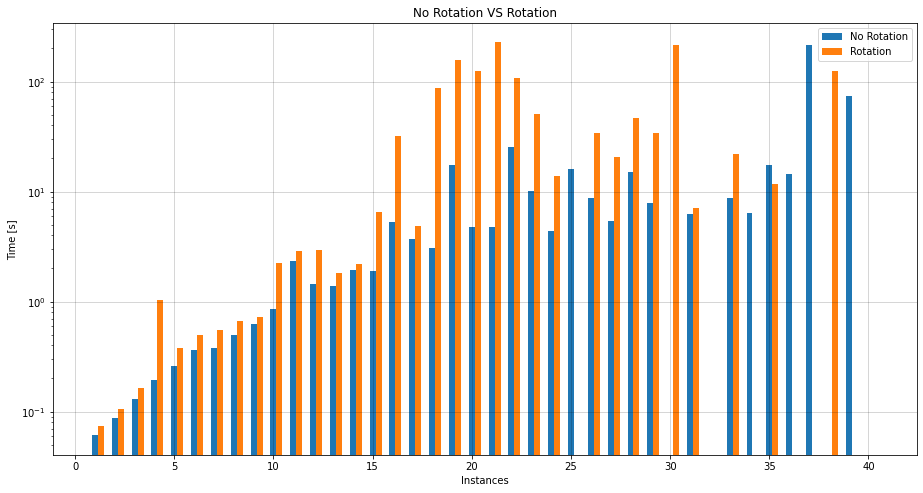

In [5]:
PlotStats({'No Rotation':rotations['time'],
            'Rotation':rotations['time_rotation']},
            x_axis=list(encodings['Instance']))